In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets,neighbors, decomposition
import time
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import matplotlib as mpl

In [2]:
adata = sc.read_h5ad('./nestorowa.data2.h5ad')
X_pca = adata.obsm['X_pca']
cell_label = adata.obs['cell_label']

In [3]:
adata

AnnData object with n_obs × n_vars = 1656 × 46078
    obs: 'cell_label'
    uns: 'iroot'
    obsm: 'X_pca'

In [4]:
sc.pp.filter_genes(adata,min_cells=1000)

In [5]:
# Select top 1000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,flavor='cell_ranger',n_top_genes=1000,log=False)
# Subset the genes
adata = adata[:, filter_result.gene_subset]

In [6]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

C:\anaconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:553: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


In [7]:
nest_dpt_pseudotime = pd.read_csv("./nest.dpt_pseudotime.csv",index_col=0).values.reshape(-1)
nest_palantir_time = pd.read_csv("./nest.palantir_pseudotime.csv",index_col=0).values.reshape(-1)
nest_monocle_time = pd.read_csv("./nest.monocle_pseudotime.csv",index_col=0).values.reshape(-1)
nest_dtne_time = pd.read_csv("./nest.dtne_pseudotime.csv",index_col=0).values.reshape(-1)

In [8]:
def correlation_comparation(list_A,list_B):
    pearsonr_res = stats.pearsonr(list_A, list_B)
    spearmanr_res = stats.spearmanr(list_A, list_B) 
    tau, p_value = stats.kendalltau(list_A, list_B)
    return pearsonr_res.statistic,spearmanr_res.statistic,tau

In [9]:
def adjacency_dist_matrix(data,k_neighbors,root_indices):
    
    n_samples = data.shape[0]
    nbrs = neighbors.NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean').fit(data)
    knn_dists, knn_indices = nbrs.kneighbors(data)
        
    indptr = range(0,(n_samples+1)*k_neighbors,k_neighbors)
    k_matrix = sparse.csr_matrix((knn_dists.flatten(),knn_indices.flatten(),indptr),shape=(n_samples,n_samples))
    adjacency_matrix = k_matrix.maximum(k_matrix.T) 
    
    geo_matrix = sparse.csgraph.dijkstra(csgraph=adjacency_matrix, directed=False, indices=root_indices, return_predecessors=False)
    
    return adjacency_matrix,geo_matrix 

In [10]:
adj,geo = adjacency_dist_matrix(X_pca,20,657)

In [11]:
nest_dtne_corr = correlation_comparation(geo,nest_dtne_time)
nest_dtne_corr

(0.9733816214852296, 0.9690765985603669, 0.8591356889531065)

In [12]:
nest_dpt_corr = correlation_comparation(geo,nest_dpt_pseudotime)
nest_dpt_corr

(0.9385436906558827, 0.9229922219059644, 0.7747255333441608)

In [13]:
nest_monocle_corr = correlation_comparation(geo,nest_monocle_time)
nest_monocle_corr

(0.7589262408956179, 0.5181856580857797, 0.3546681845381438)

In [14]:
nest_palantir_corr = correlation_comparation(geo,nest_palantir_time)
nest_palantir_corr

(0.9470383289742317, 0.8734495777598604, 0.7087379774362567)

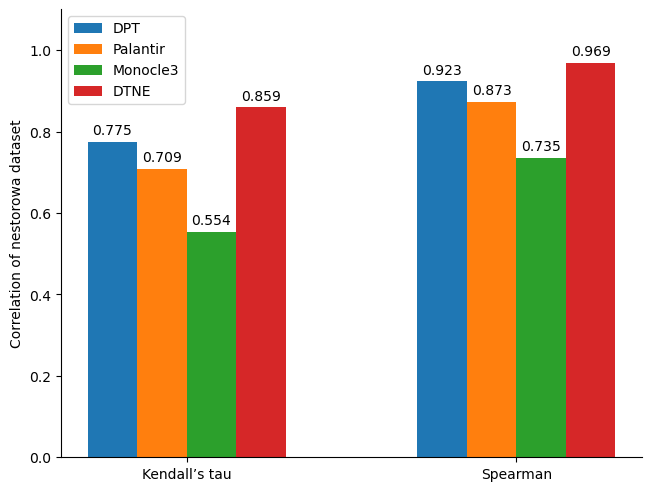

In [15]:
correlation = ['Kendall’s tau','Spearman']
pseudotime_corr = {
    'DPT':(0.775, 0.923),
    'Palantir':(0.709, 0.873),
    'Monocle3':(0.554, 0.735),
    'DTNE':(0.859, 0.969)
    }

x = np.arange(len(correlation))  # the label locations
width = 0.15  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for name, corr in pseudotime_corr.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, corr, width, label=name)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Correlation of nestorowa dataset')
ax.set_xticks(x + 1.5*width, correlation)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1.1)

sns.despine(top=True,right=True,left=False,bottom=False,)
# ax.grid(False)
# ax.tick_params(bottom=True, left=True)

plt.show()

In [16]:
import matplotlib.gridspec as gridspec

In [17]:
geo = geo/max(geo)

Text(0.5, 0, 'DTNE')

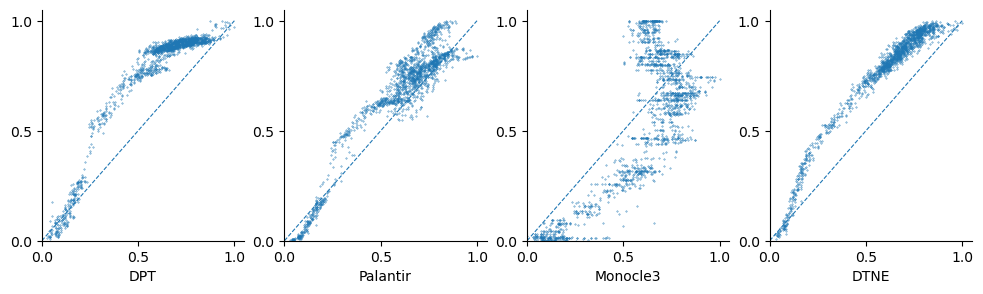

In [18]:
fig = plt.figure(figsize=(12, 3))

gs1 = gridspec.GridSpec(1, 4)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])
ax3 = fig.add_subplot(gs1[2])
ax4 = fig.add_subplot(gs1[3])

x = np.linspace(0, 1, 100)
y = x

for side in ['right','top']:
        ax1.spines[side].set_visible(False)    
ax1.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax1.set_xlim(0, 1.05)
ax1.set_ylim(0, 1.05)
ax1.set_yticks([0,0.5,1])
ax1.scatter(geo,nest_dpt_pseudotime,s=0.1)
ax1.set_xlabel('DPT')

for side in ['right','top']:
        ax2.spines[side].set_visible(False) 
ax2.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax2.set_xlim(0, 1.05)
ax2.set_ylim(0, 1.05)
ax2.set_yticks([0,0.5,1])
ax2.scatter(geo,nest_palantir_time,s=0.1)
ax2.set_xlabel('Palantir')

for side in ['right','top']:
        ax3.spines[side].set_visible(False) 
ax3.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax3.set_xlim(0, 1.05)
ax3.set_ylim(0, 1.05)
ax3.set_yticks([0,0.5,1])
ax3.scatter(geo,nest_monocle_time,s=0.1)
ax3.set_xlabel('Monocle3')

for side in ['right','top']:
        ax4.spines[side].set_visible(False) 
ax4.plot(x, y,linestyle='--',c='tab:blue',lw=.8)
ax4.set_xlim(0, 1.05)
ax4.set_ylim(0, 1.05)
ax4.set_yticks([0,0.5,1])
ax4.scatter(geo,nest_dtne_time,s=0.1)
ax4.set_xlabel('DTNE')